<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase2/blob/master/E4P2S9_Convolutional_Sentiment_Analysis_cpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Sat Mar 27 09:38:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Source : https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torch==1.5.0+cu92 torchtext==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 24kB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 1.2MB 9.1MB/s 
ERROR: torchvision 0.9.0+cu101 has requirement torch==1.8.0, but you'll have torch 1.5.0+cu92 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchtext 0.9.0
    Uninstalling torchtext-0.9.0:
      Successfully uninstalled torchtext-0.9.0


In [ ]:
import torch
from torchtext import data

#### Here we will use convolutions. Using filters, we will look at the n-grams of sentence. For example filter size nxd where n is the n-gram we need to read and d is the embedding dimension. Let us say we wish to read 3 words in a go i.e tri-gram and embedding dimension is 5, then filter we will be using is 3x5. Convolution followed by maxpooling will be fed to linear layer for sentiment prediction. Below diagramatic representation will give an idea how convolutions are used to extract features from embeddings.

#### Intuition behind using convolution layers for text: Presence of specific bi-grams or tri-grams will be indicative of the overall sentiment user is trying to present in review (movies in this example)

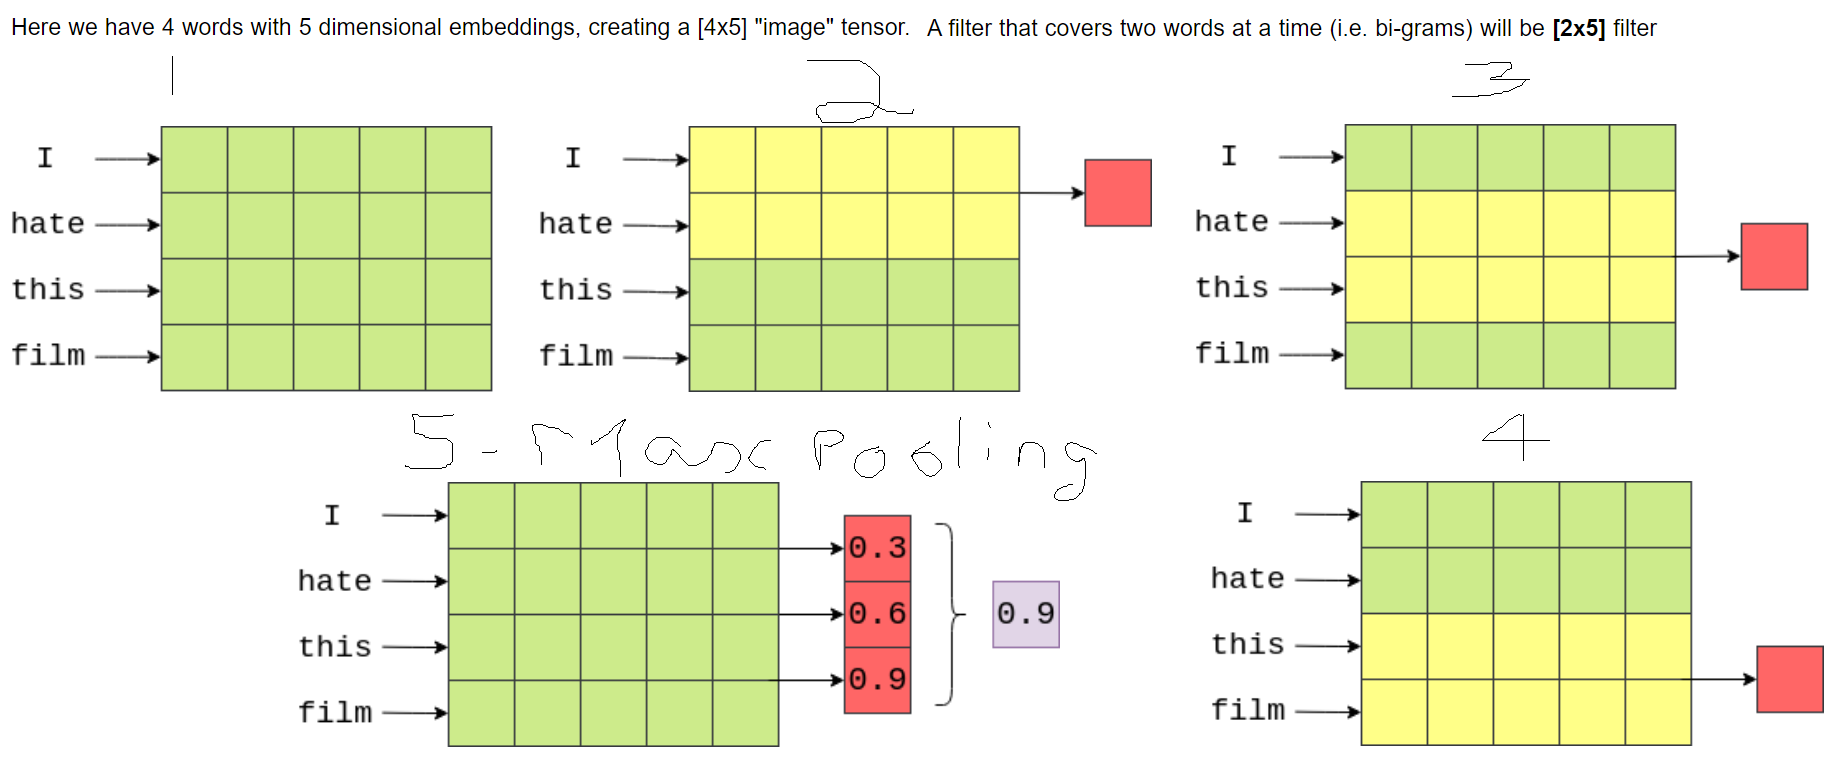

In [ ]:
SEED = 1234

torch.manual_seed(SEED)                      # We are using seed to ensure that we get similar data while splitting train & test data
torch.backends.cudnn.deterministic = True
txt = data.Field(tokenize = 'spacy', batch_first = True)   
# CNNs want batch dimensions to appear first. Hence we are giving 'batch_first = True'. This way the size of input we feed to model via iterator
# will appear automatically in the shape [batch_size, sentence length]. Without this it would be [sentence length, batch_size] 
lbl = data.LabelField(dtype = torch.float)

#### train_data is organized in such a way that a single element contains a field, 'text', along with all the tokens representing the text, and a 'label' field that contains the label of the text (eg: in this case POS, NEG for sentiment analysis)

In [ ]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(txt, lbl)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 21.4MB/s]


In [ ]:
print('Length of train_data:',len(train_data), 'Type:', type(train_data))
print('Length of test_data :',len(test_data), 'Type:', type(test_data))
print(train_data.fields)
print(test_data.fields)
print(vars(train_data.examples[0]))   # vars -> Built-in function, with an argument equivalent to object.dict. 
print(vars(test_data.examples[0])) 
print(vars(train_data[-1]))

Length of train_data: 25000 Type: <class 'torchtext.datasets.imdb.IMDB'>
Length of test_data : 25000 Type: <class 'torchtext.datasets.imdb.IMDB'>
{'text': <torchtext.data.field.Field object at 0x7eff70cb9c90>, 'label': <torchtext.data.field.LabelField object at 0x7eff70cb97d0>}
{'text': <torchtext.data.field.Field object at 0x7eff70cb9c90>, 'label': <torchtext.data.field.LabelField object at 0x7eff70cb97d0>}
{'text': ['"', 'The', 'Garden', 'of', 'Allah', '"', 'is', 'a', 'prime', 'example', 'of', '"', 'popular', 'women', "'s", 'literature', '"', ',', 'turn', 'of', 'the', 'XXth', 'century', 'style', ',', 'combining', 'all', 'the', 'power', 'of', 'unbridled', 'erotic', 'and', 'exotic', 'reveries', 'with', 'the', 'stimulating', 'glamour', 'of', 'fake', 'mysticism', 'and', 'the', 'sado', '-', 'masochistic', 'bite', 'of', 'Catholic', 'guilt', '.', 'Just', 'as', 'Jane', 'Eyre', 'could', "n't", 'really', 'be', 'happy', 'until', 'her', 'castle', 'burned', 'down', 'around', 'her', 'and', 'her', 

##### Split the train_data further into train_data & valid_data

In [ ]:
import random
train_data, valid_data = train_data.split(split_ratio=0.8,random_state=random.seed(SEED))

In [ ]:
print('Length of train_data:',len(train_data))
print('Length of valid_data:',len(valid_data))
print('Length of test_data:',len(test_data))

Length of train_data: 20000
Length of valid_data: 5000
Length of test_data: 25000


### Building vocabulary. We take only top 25,000 words. Rest will be replaced with 'unk'. Also we are going to use pre-trained vector glove.6B.100d. This means glove was trained on 6 Billion words & have 100 dimensions. unk_init is meant for initialization of out-of-vocabulary word vectors (<unk>). Please note that building vocabulary means building a dictionary of words from input document.

In [ ]:
max_vocab_size = 25_000
txt.build_vocab(train_data, max_size=max_vocab_size, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
lbl.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:42, 5.32MB/s]                          
100%|█████████▉| 398291/400000 [00:16<00:00, 24087.72it/s]

In [ ]:
print('Unique words in txt:',len(txt.vocab))   # 25,002 words because of unk & pad. Pad is used to make batch_size same for shorter sentences
print('Unique words in lbl:',len(lbl.vocab))

Unique words in txt: 25002
Unique words in lbl: 2


In [ ]:
print(txt.vocab.freqs.most_common(25))  # Printing most commonly occuring 25 words

[('the', 232566), (',', 221601), ('.', 189994), ('and', 125842), ('a', 125171), ('of', 115585), ('to', 107955), ('is', 87702), ('in', 70348), ('I', 61932), ('it', 61383), ('that', 56634), ('"', 50808), ("'s", 49807), ('this', 48581), ('-', 42622), ('/><br', 40815), ('was', 39942), ('as', 34992), ('with', 34495), ('movie', 33860), ('for', 33848), ('film', 31186), ('The', 30071), ('but', 28059)]


## How to see vocabulary directly ? 
We can  see the vocabulary directly using either the stoi (string to int) or itos (int to string) method.

In [ ]:
print(txt.vocab.itos[:10])     # First 10
print(txt.vocab.itos[77:90])   # In between
print(txt.vocab.itos[-10:])    # Last 10. 

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']
['story', 'were', 'see', 'even', 'their', 'no', 'my', 'does', 'did', 'me', 'than', '...', 'much']
['gallows', 'gamers', 'gazes', 'gem.<br', 'generals', 'gentlemanly', 'gets.<br', 'ghettos', 'gialli', 'gin']


In [ ]:
print(txt.vocab.stoi)
print(lbl.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7eff70cb9450>>, {'<unk>': 0, '<pad>': 1, 'the': 2, ',': 3, '.': 4, 'and': 5, 'a': 6, 'of': 7, 'to': 8, 'is': 9, 'in': 10, 'I': 11, 'it': 12, 'that': 13, '"': 14, "'s": 15, 'this': 16, '-': 17, '/><br': 18, 'was': 19, 'as': 20, 'with': 21, 'movie': 22, 'for': 23, 'film': 24, 'The': 25, 'but': 26, '(': 27, ')': 28, "n't": 29, 'on': 30, 'you': 31, 'are': 32, 'not': 33, 'have': 34, 'his': 35, 'be': 36, 'he': 37, 'one': 38, '!': 39, 'at': 40, 'by': 41, 'all': 42, 'an': 43, 'who': 44, 'from': 45, 'they': 46, 'like': 47, 'so': 48, 'her': 49, "'": 50, 'has': 51, 'or': 52, 'about': 53, 'out': 54, 'It': 55, 'just': 56, 'do': 57, '?': 58, 'some': 59, 'good': 60, 'more': 61, 'would': 62, 'very': 63, 'up': 64, 'what': 65, 'This': 66, 'there': 67, 'time': 68, 'can': 69, 'when': 70, 'which': 71, 'she': 72, 'had': 73, 'only': 74, 'if': 75, 'really': 76, 'story': 77, 'were': 78, 'see': 79, 'even': 80, 'their': 81, 

#### Creating iterator. Using bucket-iterator that will return batch of examples where each example is of similar length, minimizing the amount of padding per example. 

In [ ]:
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), 
                                                                            batch_size = batch_size,
                                                                            device = device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
     def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
         super().__init__()
         self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)  
         # We are passing idx of padded tokens so that we can avoid learning embeddings for <pad> token. 
         # <pad> tokens are irrelevant for our task here - ie predicting sentiment from movie reviews. 
         self.conv_0    = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[0],embedding_dim))
         self.conv_1    = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[1],embedding_dim))
         self.conv_2    = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[2],embedding_dim))

         self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)  # --> len(filter_sizes) = 3, n_filters = 100, so 3*100 input -> 1 output

         self.dropout = nn.Dropout(dropout)
     
     def forward(self, text):  
         #text = [batch size, sentence len] --> eg: [64, 1150] means 64 sentences with 1150 words each. Length of sentence will vary for each batch.
         #we are getting this shape where batch_size comes first is because we gave 'batch_first = True' while data pre-processing
         embedded = self.embedding(text)
         #embedded = [batch size, sentence len, emb dim] --> [64, 1150, 100] adding one more dimension for embed dimension

         embedded = embedded.unsqueeze(1)  
         #embedded = [batch size, 1, sentence len, emb dim] --> [64, 1, 1150, 100]

         conv_0 = F.relu(self.conv_0(embedded).squeeze(3))  # torch.Size([64, 100, 1148])
         conv_1 = F.relu(self.conv_1(embedded).squeeze(3))  # torch.Size([64, 100, 1147])
         conv_2 = F.relu(self.conv_2(embedded).squeeze(3))  # torch.Size([64, 100, 1146])
         #conv_n = [batch size, n_filters, sentence len - filter_sizes[n] + 1]
         
         pool_0 = F.max_pool1d(conv_0, conv_0.shape[2]).squeeze(2)  # Kernel size of max pool -> sentence len - filter_sizes[n] + 1 --> 1148, 1147 etc.
         pool_1 = F.max_pool1d(conv_1, conv_1.shape[2]).squeeze(2)  # Output size of max pool is [batch size, n_filters, 1] --> [64, 100, 1]
         pool_2 = F.max_pool1d(conv_2, conv_2.shape[2]).squeeze(2)  # squeeze(2) will make it [batch size, n_filters]  --> [64, 100]
         #pool_n = [batch size, n_filters]

         cat = self.dropout(torch.cat((pool_0, pool_1, pool_2), dim=1)) # cat = [batch size, n_filters * len(filter_sizes)] --> torch.Size([64, 300])
         return self.fc(cat)  

In [ ]:
input_dim = len(txt.vocab)   # 25002
embedding_dim = 100          # EMBEDDING_DIM must be equal to that of the pre-trained GloVe vectors loaded earlier (glove.6B.100d) 
n_filters     = 100
filter_sizes  = [3,4,5]      # We are using tri-grams, 4-grams and 5-grams 
output_dim    = 1            # only 2 values - pos or neg as this is sentiment analysis
dropout       = 0.5
pad_idx       = txt.vocab.stoi[txt.pad_token]   #we are finding index of pad token i.e. we are finiding index of <pad> in vocabulary we built

model = CNN(input_dim, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,620,801 trainable parameters


### Installing torchsummaryx. We can see model summary like we see using 'torchsummary' in vision. 

In [ ]:
! pip install torchsummaryX

In [ ]:
from torchsummaryX import summary
inputs = torch.zeros((1, 100), dtype=torch.long)
summary(model.to(device), inputs.to(device))

                 Kernel Shape     Output Shape   Params Mult-Adds
Layer                                                            
0_embedding      [100, 25002]    [1, 100, 100]  2.5002M   2.5002M
1_conv_0     [1, 100, 3, 100]  [1, 100, 98, 1]    30.1k     2.94M
2_conv_1     [1, 100, 4, 100]  [1, 100, 97, 1]    40.1k     3.88M
3_conv_2     [1, 100, 5, 100]  [1, 100, 96, 1]    50.1k      4.8M
4_dropout                   -         [1, 300]        -         -
5_fc                 [300, 1]           [1, 1]    301.0     300.0
--------------------------------------------------------------------
                         Totals
Total params          2.620801M
Trainable params      2.620801M
Non-trainable params        0.0
Mult-Adds              14.1205M


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_embedding,"[100, 25002]","[1, 100, 100]",2500200.0,2500200.0
1_conv_0,"[1, 100, 3, 100]","[1, 100, 98, 1]",30100.0,2940000.0
2_conv_1,"[1, 100, 4, 100]","[1, 100, 97, 1]",40100.0,3880000.0
3_conv_2,"[1, 100, 5, 100]","[1, 100, 96, 1]",50100.0,4800000.0
4_dropout,-,"[1, 300]",NaN,NaN
5_fc,"[300, 1]","[1, 1]",301.0,300.0


#### Copying the pre-trained word embeddings (txt.vocab that we built using 'build_vocab') we loaded earlier into the embedding layer of our model

In [ ]:
pretrained_embeddings = txt.vocab.vectors
print(pretrained_embeddings.shape)
print(txt.vocab.vectors.shape)

torch.Size([25002, 100])
torch.Size([25002, 100])


#### Replace the initial weights of the embedding layer with the pre-trained embeddings.

In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.6740,  0.6434, -0.2475,  ...,  0.9460, -0.5936,  0.6230],
        [-0.0495,  0.6333, -0.0872,  ..., -0.2504,  0.6853, -0.3435],
        [-0.8045, -0.4367, -0.1177,  ..., -0.0919,  0.2595,  0.6334]],
       device='cuda:0')

##### Manually setting rows corresponding to 'unk' and 'pad' in the embedding weights matrix to zeros.

In [ ]:
unk_idx = txt.vocab.stoi[txt.unk_token]
print('unk_idx, txt.unk_token :', unk_idx, txt.unk_token)
model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)
print(model.embedding.weight.data.shape)

unk_idx, txt.unk_token : 0 <unk>
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.6740,  0.6434, -0.2475,  ...,  0.9460, -0.5936,  0.6230],
        [-0.0495,  0.6333, -0.0872,  ..., -0.2504,  0.6853, -0.3435],
        [-0.8045, -0.4367, -0.1177,  ..., -0.0919,  0.2595,  0.6334]],
       device='cuda:0')
torch.Size([25002, 100])


##### SGD updates all parameters with the same learning rate and choosing this learning rate can be tricky. Adam adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates. Hence using Adam in this example

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division, 'correct' tensor will have 1 if 'preds == y' & 0 if 'preds != y'
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for idx, batch in enumerate(iterator):       
        optimizer.zero_grad()      
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc  = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()    

    return epoch_loss / len(iterator), epoch_acc / len(iterator)   

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        for idx, batch in enumerate(iterator):      
            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc  = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc  += acc.item() 

    return epoch_loss / len(iterator), epoch_acc / len(iterator)       

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training for 20 epochs is good enough beacuse training accuracy reaches 99.+% by then

In [ ]:
n_epochs = 20
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/gdrive/My Drive/EVA4P2_S9/E4P2_S9_Convolution_Senti_Analysis_D03262021_V1.pt')
        print('Model Saved in epoch:', epoch)
       
    if (epoch % 5 == 0) or (epoch == (n_epochs-1)):
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Model Saved in epoch: 0
Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 0.635 | Train Acc: 63.31%
	 Val. Loss: 0.463 |  Val. Acc: 80.10%
Model Saved in epoch: 1
Model Saved in epoch: 2
Model Saved in epoch: 3
Epoch: 06 | Epoch Time: 0m 24s
	Train Loss: 0.104 | Train Acc: 96.38%
	 Val. Loss: 0.328 |  Val. Acc: 87.80%
Epoch: 11 | Epoch Time: 0m 24s
	Train Loss: 0.023 | Train Acc: 99.39%
	 Val. Loss: 0.479 |  Val. Acc: 87.88%
Epoch: 16 | Epoch Time: 0m 24s
	Train Loss: 0.011 | Train Acc: 99.72%
	 Val. Loss: 0.625 |  Val. Acc: 87.42%
Epoch: 20 | Epoch Time: 0m 24s
	Train Loss: 0.010 | Train Acc: 99.70%
	 Val. Loss: 0.738 |  Val. Acc: 86.87%


In [ ]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/EVA4P2_S9/E4P2_S9_Convolution_Senti_Analysis_D03262021_V1.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.334 | Test Acc: 86.11%


##### Giving user input to get the sentiment back. Please note that we trained on movie review comments, hence input also should be similar text.

In [ ]:
import spacy
nlp = spacy.load('en')  #'en' is language_id that indicates english

# The input sentence has to be at least as long as the largest filter height used (in our case 5 because we gave [3, 4, 5]). Else CNN will break due
# to Max-pooling filter size vs sentence length issue. Max pool filter wont be able to cover even one pooling if sent length < max pool filter height.
# Hence, we modify our predict_sentiment function to also accept a minimum length argument. 
# If the tokenized input sentence is less than min_len tokens, we append padding tokens (<pad>) to make it min_len tokens.

def predict_sentiment(model, sentence, min_len = 5):  # We are giving min_len = 5 bcoz. ie largest Maxpool filter we used
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]   # tokenizing the sentence
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))  # Padding tokens to match it with min_len 
    indexed = [txt.vocab.stoi[t] for t in tokenized]  # indexes the tokens by converting them into their integer representation from our vocabulary
    # "pathetic movie" --> indexed representation will be [1316, 22, 1, 1, 1] , 1316 ->pathetic , 22-> movie, 1 -> <pad> 
    tensor  = torch.LongTensor(indexed).to(device)  # converts 'indexed' which is a Python list into a PyTorch tensor
    tensor = tensor.unsqueeze(0)  # adding batch dimension to feed it to GPU
    prediction    = torch.sigmoid(model(tensor)) # Using sigmoid to keep the predictions between 0 & 1
    return prediction.item()

In [ ]:
predict_sentiment(model, "pathetic movie")

0.006700256373733282

In [ ]:
predict_sentiment(model, "a pathetic movie") 

0.01830856129527092

In [ ]:
predict_sentiment(model, "simply superb")

0.9549455046653748

In [ ]:
predict_sentiment(model, "one time watch")

0.4930930733680725

In [ ]:
predict_sentiment(model, "not that bad")  # ------> # Still This is a problem. Negative words 'not', 'bad' etc. are bringing the score down

0.2748599052429199

In [ ]:
predict_sentiment(model, "this movie is not that bad") # increasing length improves score. Could be bcoz. IMDB movie reviews against which network
# is trained has minimum 5 words

0.43943092226982117

### Saving vocab in gdrive for future use so that we dont have to rebuild vocab using IMDB dataset & glove again.

In [ ]:
def save_vocab(vocab, path):
    import pickle
    output = open(path, 'wb')
    pickle.dump(vocab, output)
    output.close()

In [ ]:
save_vocab({ 'txt.vocab': txt.vocab, 'lbl.vocab': lbl.vocab }, '/content/gdrive/My Drive/EVA4P2_S9/conv_senti_analysis_vocab.pkl')

/usr/local/lib/python3.7/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


#### We need to use scripted model since traced model will make the shapes constant and we wont be able to use variable length strings

In [ ]:
scripted_model = torch.jit.script(model.to('cpu'))

In [ ]:
scripted_model(torch.zeros((1, 5), dtype=torch.long))

tensor([[-0.0551]], grad_fn=<AddBackward0>)

In [ ]:
scripted_model.save('/content/gdrive/My Drive/EVA4P2_S9/E4P2_S9_Conv_Senti_Analysis_CPU_Scripted_D0326v1.pt')

# Code for eval section i.e. loading scripted model saved as CPU & prediction

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install torch==1.5.0+cu92 torchtext==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
import torch
import torchtext
#from torchtext import data
import spacy
import pickle
import os 
from pathlib import Path

In [4]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz#egg=en_core_web_sm==2.3.1

In [5]:
import en_core_web_sm

In [6]:
vocab_path = Path(f"/content/gdrive/My Drive/EVA4P2_S9/conv_senti_analysis_vocab.pkl")

In [7]:
with vocab_path.open("rb") as vocab_file:
    vocab = pickle.load(vocab_file)

In [8]:
txt = vocab["txt.vocab"]
lbl = vocab["lbl.vocab"]

In [9]:
model = torch.load('/content/gdrive/My Drive/EVA4P2_S9/E4P2_S9_Conv_Senti_Analysis_CPU_Scripted_D0326v1.pt')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:590: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


In [10]:
#nlp = spacy.load('en')  #'en' is language_id that indicates english
nlp = en_core_web_sm.load()

# The input sentence has to be at least as long as the largest filter height used (in our case 5 because we gave [3, 4, 5]). Else CNN will break due
# to Max-pooling filter size vs sentence length issue. Max pool filter wont be able to cover even one pooling if sent length < max pool filter height.
# Hence, we modify our predict_sentiment function to also accept a minimum length argument. 
# If the tokenized input sentence is less than min_len tokens, we append padding tokens (<pad>) to make it min_len tokens.

def predict_sentiment_cpu(model, sentence, min_len = 5):  # We are giving min_len = 5 bcoz. ie largest Maxpool filter we used
    #model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]   # tokenizing the sentence
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))  # Padding tokens to match it with min_len 
    indexed = [txt.stoi[t] for t in tokenized]  # indexes the tokens by converting them into their integer representation from our vocabulary
    # "pathetic movie" --> indexed representation will be [1316, 22, 1, 1, 1] , 1316 ->pathetic , 22-> movie, 1 -> <pad> 
    tensor  = torch.LongTensor(indexed)  # converts 'indexed' which is a Python list into a PyTorch tensor
    tensor = tensor.unsqueeze(0).to('cpu')  # adding batch dimension to feed it to GPU
    with torch.no_grad():
        prediction    = torch.sigmoid(model(tensor)) # Using sigmoid to keep the predictions between 0 & 1
    return prediction.item()

In [13]:
predict_sentiment_cpu(model, "pretty superb")

0.9576189517974854